# Comparación de modelos

En la sesión anterior vimos como evaluar la calidad de un modelo empleando diferentes tipos de métricas. En esta sesión vamos a ver como realizar comparaciones estadísticas entre predictores en diferentes situaciones. 



In [34]:
pip install numpy pandas scikit-learn statsmodels pingouin

Note: you may need to restart the kernel to use updated packages.


## 1. Dos predictores en un dominio

A continuación veremos como comparar dos modelos en un único dominio. Es decir, veremos cómo determinar si los resultados de dos modelos diferentes resolviendo exactamente el mismo problema son significativamente diferentes.

### 1.1. Caso paramétrico
Imaginaos que para un determinado conjunto de datos hemos probado dos clasificadores diferentes: un árbol C50 y una red neuronal. Cada clasificador se ha evaluado utilizando una validación cruzada con 10 pliegues. En el fichero `ejemplo1.dat` podeis encontrar el índice Kappa para cada uno de los pliegues. Con estos datos ¿qué clasificador funciona mejor?

In [1]:
import pandas as pd
import numpy as np

results = pd.read_csv('./Datos/data/ejemplo1.dat')
results

,nnet,C50
0,0.814815,0.666667
1,0.589744,0.764706
2,0.600000,0.818182
3,0.179487,0.294118
4,0.814815,1.000000
5,0.000000,-0.111111
6,0.000000,0.333333
7,0.764706,0.764706
8,0.818182,0.818182
9,0.000000,-0.111111


Como podemos observar estamos comparando dos clasificadores en un mismo dominio, para lo que podemos usar un test **T de Student**. Pero antes debemos comprobar si se cumplen las **condiciones** necesarias para realizar dicho test con medidas pareadas: **normalidad** y homogeneidad de las varianzas (**homocedasticidad**). 

Para comprobar la normalidad podemos varios tests: el test de Shapiro-Wilk, el test de Kolmogorov-Smirnov con la corrección Lilliefors, el test de Jarque-Bera. El test de **Shapiro-Wilk** se recomienda cuando el **número de muestras es pequeño (<50)**. Para muestras más grandes es mejor emplear los otros tests. El test de **Jarque-Bera está recomendado solo para muestras muy grandes (>1000)**.

Recordad que **la normalidad hay que comprobarla sobre las diferencias entre las medidas** obtenidas en cada pliegue, ya que lo que queremos comprobar es si existen diferencias significativas entre las medias del rendimiento entre las dos clasificadores. En nuestro caso el test intenta comprobar estas hipótesis:

$$ H_0: X \sim N(\mu, \sigma^2) $$
$$ H_1: X \nsim N(\mu, \sigma^2) $$

In [2]:
from pingouin import normality

shapiro = normality(results['nnet'] - results['C50'], method='shapiro')

print('### Test de normalidad Shapiro-Wilk')
print(f'### estadístico = {shapiro.W.values[0]:.4f}, p-value = {shapiro.pval.values[0]:.4f}')

normtest = normality(results['nnet'] - results['C50'], method='normaltest')

print('### Test de normalidad omnibus')
print(f'### estadístico = {normtest.W.values[0]:.4f}, p-value = {normtest.pval.values[0]:.4f}')

jaquebera = normality(results['nnet'] - results['C50'], method='jarque_bera')

print('### Test de normalidad Jaque-Bera')
print(f'### estadístico = {jaquebera.W.values[0]:.4f}, p-value = {jaquebera.pval.values[0]:.4f}')

### Test de normalidad Shapiro-Wilk
### estadístico = 0.9353, p-value = 0.5018
### Test de normalidad omnibus
### estadístico = 1.1442, p-value = 0.5644
### Test de normalidad Jaque-Bera
### estadístico = 0.6761, p-value = 0.7132


/Users/luisi/Documents/Master-Big-Data/Minería de datos/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


Como podemos ver, **no podemos rechazar la hipótesis nula** (la muestra procede de una distribución normal) con un 95% de confianza en ninguno de los casos puesto que todos los **p-valores son mayores que 0.05**. 
Recordad que en este caso sólo nos habría hecho falta aplicar el test de Shapiro-Wilk al ser la muestra menor que 50 observaciones.

Una vez comprobada la normalidad, hay que proceder con la comprobación de **la homocedasticidad** (homogeneidad de las varianzas). Para ello tenemos dos test: el **test de Levene** y el **test de Bartlett**. Este último es más potente en el caso de que se pueda asumir la normalidad, como es nuestro caso.

In [ ]:
from pingouin import homoscedasticity

levene = homoscedasticity(results[['nnet', 'C50']], method='levene')

print('### Test de Levene para la homogeneidad de las varianzas')
print(f'### estadístico = {levene.W.values[0]:.4f}, p-value = {levene.pval.values[0]:.4f}')

bartlett = homoscedasticity(results[['nnet', 'C50']], method='bartlett')

print('### Test de Bartlett para la homogeneidad de las varianzas')
print(f"### estadístico = {bartlett['T'].values[0]:.4f}, p-value = {bartlett.pval.values[0]:.4f}")

### Test de Levene para la homogeneidad de las varianzas
### estadístico = 0.0017, p-value = 0.9672
### Test de Bartlett para la homogeneidad de las varianzas
### estadístico = 0.0530, p-value = 0.8179


Igual que en el caso anterior, **no podemos rechazar la hipótesis nula** de que las varianzas en las medidas obtenidas en cada clasificador sean homogéneas.

Al cumplirse las condiciones de aplicabilidad del test T de Student con medidas pareadas, podemos comprobar si las diferencias detectadas en los clasificadores es significativa o no. Es decir, las hipótesis que intenta comprobar el test se pueden expresar de la siguiente manera:

$$ H_0: \mu_{C50} − \mu_{nnet} = 0 $$
$$ H_q: \mu_{C50} − \mu_{nnet} \neq 0 $$

In [4]:
from pingouin import ttest

t = ttest(results['nnet'], results['C50'], paired=True)

print('### Test T de medias pareadas')
print(f"### estadistico = {t['T'].values[0]:.4f}, p-value = {t['p-val'].values[0]:.4f}")

### Test T de medias pareadas
### estadistico = -1.2692, p-value = 0.2362


Observando estos resultados, vemos que **no podemos rechazar $H_0$** (la diferencia de medias es igual a 0), por lo que podemos concluir que con el **95% de confianza** que **no existen diferencias significativas entre los dos clasificadores** con el conjunto de datos utilizado. 

En este caso, tambien se podría haber aplicado un test T de Student para una muestra con la diferencia de medias, probando esa diferencia sea 0:

In [5]:
from pingouin import ttest

t = ttest(results['nnet'] - results['C50'], 0)

print('### Test T de medias pareadas')
print(f"### estadistico = {t['T'].values[0]:.4f}, p-value = {t['p-val'].values[0]:.4f}")

### Test T de medias pareadas
### estadistico = -1.2692, p-value = 0.2362


### 1.2. Caso no paramétrico

Supongamos ahora que queremos comparar otros dos clasificadores, en este caso una máquina de soporte vectorial (SMV) y un análisis lineal discriminante (LDA). Siguiendo el esquema del caso anterior, los modelos se han entrenado y evaluado mediante una validación cruzada con 10 pliegues. En el fichero `ejemplo2.dat` podeis encontrar los valores para la precisión para cada uno de los pliegues:

In [6]:
results = pd.read_csv('./Datos/data/ejemplo2.dat')
results

,SVM,LDA
0,0.933333,0.933333
1,0.875000,0.875000
2,0.812500,0.875000
3,0.812500,0.875000
4,0.933333,0.933333
5,0.800000,0.800000
6,0.600000,0.533333
7,0.937500,0.937500
8,0.750000,0.937500
9,0.800000,0.733333


Igual que en el caso anterior, lo primero que haremos será **comprobar las condiciones de aplicabilidad del test T de Student** con medidas pareadas. Primero comprobamos la normalidad de la muestra:

In [7]:
from pingouin import normality

shapiro = normality(results['SVM'] - results['LDA'], method='shapiro')

print('### Test de normalidad Shapiro-Wilk')
print(f"### estadístico = {shapiro.W.values[0]:.4f}, p-value = {shapiro.pval.values[0]:.4f}")

### Test de normalidad Shapiro-Wilk
### estadístico = 0.8363, p-value = 0.0399


Puesto que el **p-valor obtenido es < 0.05**, podemos afirmar que las muestras no proceden de una distribución normal con el 95% de confianza. Es decir, **podemos rechazar la hipótesis nula** de que la muestra proviene de una distribución normal. Por lo tanto, **no podemos aplicar el test T de Student** para muestras pareadas (o su versión para una muestra). En este caso tenemos que aplicar los **test no paramétricos** como el test de McNemar o el test de la suma de rangos de Wilcoxon para muestras pareadas.

Empecemos por el **test de McNemar**, que necesita como datos la **matriz de confusión** para los dos métodos considerados. Teneis disponible dicha matriz en el fichero `matrizConfEjemplo2.dat`:

In [8]:
matrix = pd.read_csv('./Datos/data/matrizConfEjemplo2.dat', index_col=0)
matrix

,FALLECE,VIVE
FALLECE,31,11
VIVE,17,136


**El test de McNemar** comprueba si las **proporciones de error son iguales**, es decir:
$$ H_0: p_{FP}=p_{FN} $$
$$ H_1: p_{FP} \neq p_{FN} $$

In [9]:
from statsmodels.stats.contingency_tables import mcnemar
from pingouin import chi2_mcnemar, read_dataset

observed = pd.DataFrame([{"actual": 0,"predicted": 0}] * matrix['FALLECE']['FALLECE'] + [{"actual": 0,"predicted": 1}] * matrix['FALLECE']['VIVE'] + [{"actual": 1,"predicted": 0}] * matrix['VIVE']['FALLECE'] + [{"actual": 1,"predicted": 1}] * matrix['VIVE']['VIVE'])

mcnemar = chi2_mcnemar(observed, "predicted", "actual")

print('### Test de McNemar')
print(f"### estadistico = {mcnemar[1].chi2.values[0]:.4f}, p-value = {mcnemar[1]['p-exact'].values[0]:.4f}")

### Test de McNemar
### estadistico = 0.8929, p-value = 0.3449


En este caso **no podemos rechazar la hipotesis nula**, es decir, no podemos afirmar, con el 95% de confianza, que las proporciones de error sean distintas ni que se aprecien diferencias significativas entre los modelos.

Tambien podríamos haber usado el **test de Wilcoxon**, que compara las medianas de las dos muestras en vez de las medias. Las hipótesis que comprueba este test se pueden expresar de la siguiente manera:

$$ H0: \eta_{SVM} = \eta_{LDA} $$
$$ H1: \eta_{SVM} \neq \eta_{LDA} $$

In [10]:
from pingouin import wilcoxon

wil = wilcoxon(results['SVM'], results['LDA'])

print('### Test de signos de Wilcoxon')
print(f"### estadistico = {wil['W-val'].values[0]:.4f}, p-value = {wil['p-val'].values[0]:.4f}")

### Test de signos de Wilcoxon
### estadistico = 7.0000, p-value = 1.0000


Analizando los resultados, podemos afirmar que **no podemos rechazar la hipótesis nula** de que las medianas de las muestras sean iguales con un 95% de confianza. Es decir, **las diferencias entre los dos modelos no son estadísticamente significativas**.

## 2. Dos predictores en múltiples dominios

Hasta ahora hemos estado evaluando dos predictores sobre un único dominio. Pero muchas veces nos interesa dos  predictores sobre diferentes dominios. Es decir, comparar dos modelos a la hora de resolver mas de un problema. En este ejemplo, dos predictores se han utilizado con 10 conjuntos de datos. Concretamente, se ha calculado la precisión de una máquina de soporte vectorial (SVM) con kernel lineal y un árbol C50 en cada uno de los 10 conjuntos de datos. Podeis encontrar los resultados de las evaluaciones en el fichero `ejemplo3.dat`:

In [11]:
results = pd.read_csv('./Datos/data/ejemplo3.dat')
results

,Dataset,SVMLinear,C50
0,hepatitis,0.844167,0.862917
1,iris,0.960000,0.946667
2,cox2,0.805042,0.835291
3,oil,0.969167,0.959798
4,dhfr,0.926136,0.910701
5,German,0.747000,0.756000
6,Seg,0.803320,0.845929
7,Breast,0.964244,0.961407
8,Pima,0.773445,0.757861
9,Sonar,0.745606,0.832078


Para comparar dos modelos empleando múltiples dominios la recomendación es utilizar el **test de la suma de rangos de Wilcoxon para muestras pareadas** (o su versión de una muestra, calculando la diferencia en las metricas obtenida en cada dataset).

In [12]:
from pingouin import wilcoxon

wil = wilcoxon(results['SVMLinear'], results['C50'])

print('### Test de signos de Wilcoxon')
print(f"### estadistico = {wil['W-val'].values[0]:.4f}, p-value = {wil['p-val'].values[0]:.4f}")

### Test de signos de Wilcoxon
### estadistico = 19.0000, p-value = 0.4316


Viendo el p-valor, **no podemos rechazar la hipotesis nula**, por lo que no podemos decir que existan diferencias significativas entre la precisión de los dos clasificadores sobre los conjuntos de datos seleccionados.

## 3. Múltiples predictores en múltiples dominios

Hasta ahora nos hemos limitado a comparar 2 métodos en uno o múltiples dominios y a ver si hay diferencias significativas entre ellos. A continuación veremos como podemos extender estas técnicas para comparar múltiples modelos en multiples dominios.

### 3.1. Caso paramétrico

En el fichero `ejemplo4.dat` tenemos los resultados de precisión de tres clasificadores para 10 conjuntos de datos diferentes. Nuestro objetivo será determinar si existen diferencias significativas entre los distintos clasificadores en dichos conjunto de datos.

In [13]:
data = pd.read_csv('./Datos/data/ejemplo4.dat', header=0)
data.columns = ['dataset', 'Classifier A', 'Classifier B', 'Classifier C']

data

,dataset,Classifier A,Classifier B,Classifier C
0,1,0.8583,0.7586,0.8419
1,2,0.8591,0.7318,0.8590
2,3,0.8612,0.6908,0.8383
3,4,0.8582,0.7405,0.8511
4,5,0.8628,0.7471,0.8638
5,6,0.8642,0.6590,0.8120
6,7,0.8591,0.7625,0.8638
7,8,0.8610,0.7510,0.8675
8,9,0.8595,0.7050,0.8803
9,10,0.8612,0.7395,0.8718


Para comparar múltiples clasificadores en múltiples dominios aplicaremos el **test ANOVA de una vía para medidas pareadas** o su equivalente no paramétrico, el **test de Friedman**. 

Antes de aplicar el test, comprobemos de forma descriptiva cómo se distribuyen los datos. Para ello, primero transformaremos el conjunto de datos a un [formato de tabla larga](https://pingouin-stats.org/build/html/faq.html#what-s-the-difference-between-wide-format-and-long-format-data-and-how-can-i-convert-my-data-from-one-to-the-other): 

In [14]:
data = data.melt(id_vars='dataset', value_vars=['Classifier A', 'Classifier B', 'Classifier C'], var_name='Method', value_name='Precision')

data

,dataset,Method,Precision
0,1,Classifier A,0.8583
1,2,Classifier A,0.8591
2,3,Classifier A,0.8612
3,4,Classifier A,0.8582
4,5,Classifier A,0.8628
5,6,Classifier A,0.8642
6,7,Classifier A,0.8591
7,8,Classifier A,0.8610
8,9,Classifier A,0.8595
9,10,Classifier A,0.8612


Hagamos primero un análisis descriptivo y gráfico: 

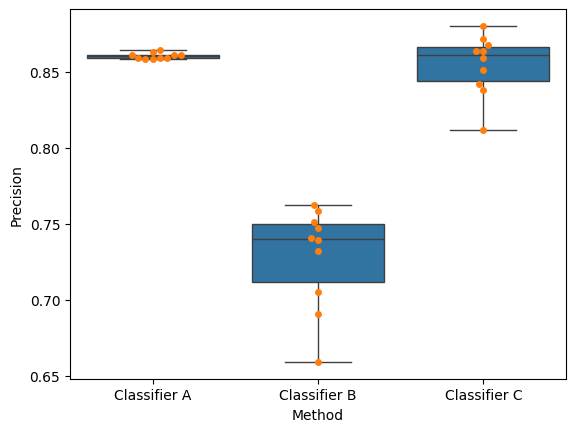

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.boxplot(x='Method', y='Precision', data=data)
ax = sns.swarmplot(x='Method', y='Precision', data=data)
plt.show()

In [16]:
print('Precision media y desviación típica por método:')
data.groupby('Method')['Precision'].agg(['mean', 'std'])

Precision media y desviación típica por método:


,mean,std
Method,,
Classifier A,0.86046,0.001979
Classifier B,0.72858,0.033323
Classifier C,0.85495,0.019900


Aunque a simple vista se puede comprobar que no tienen la misma media, realizaremos dicha comprobación a través del **test de ANOVA**. 
Para ello debemos de comprobar las **condiciones de aplicabilidad**: normalidad y esfericidad (el equivalente a la homocedasticidad para el ANOVA de medidas pareadas).

En el caso del test ANOVA de una vía para medidas pareadas se comprueba si las medias entre los diferentes clasificadores son iguales, es decir:

$$ H0: \mu_1 = \mu_2 = \dots = \mu_n $$
$$ H1: \text{las medias no son iguales} $$

Para la condición de normalidad, debemos comprobar que la muestra de cada uno de los grupos procede de una población con distribución normal. Como hemos comentado anteriormente, esto se puede realizar mediante el test de Shapiro-Wilks:

In [17]:
from pingouin import normality

shapiro_a = normality(data.loc[data["Method"] == "Classifier A"]['Precision'], method='shapiro')
shapiro_b = normality(data.loc[data["Method"] == "Classifier B"]['Precision'], method='shapiro')
shapiro_c = normality(data.loc[data["Method"] == "Classifier C"]['Precision'], method='shapiro')

print('### Test de normalidad Shapiro-Wilk para el clasificador A')
print(f'### estadístico = {shapiro_a.W.values[0]:.4f}, p-value = {shapiro_a.pval.values[0]:.4f}')

print('### Test de normalidad Shapiro-Wilk para el clasificador B')
print(f'### estadístico = {shapiro_b.W.values[0]:.4f}, p-value = {shapiro_b.pval.values[0]:.4f}')

print('### Test de normalidad Shapiro-Wilk para el clasificador C')
print(f'### estadístico = {shapiro_c.W.values[0]:.4f}, p-value = {shapiro_c.pval.values[0]:.4f}')

### Test de normalidad Shapiro-Wilk para el clasificador A
### estadístico = 0.9189, p-value = 0.3477
### Test de normalidad Shapiro-Wilk para el clasificador B
### estadístico = 0.8741, p-value = 0.1114
### Test de normalidad Shapiro-Wilk para el clasificador C
### estadístico = 0.9258, p-value = 0.4083


Como se puede deducir de los datos, las precisiones obtenidas por cada clasificador en cada uno de los conjuntos de datos **proceden de una distribución normal con un 95% de confianza**. 

El siguiente paso es comprobar la **homogeneidad de las varianzas**, que en el caso de un ANOVA con medidas repetidas se traduce en comprobar la **esfericidad** de la matriz de covarianzas. 

In [18]:
from pingouin import sphericity

esfericidad = sphericity(data = data, dv = 'Precision', within = 'Method', subject = 'dataset', alpha = 0.05)

print(f'Estadistico: {esfericidad.W:.3f} p-value: {esfericidad.pval:.4f}')

Estadistico: inf p-value: 1.0000


/Users/luisi/Documents/Master-Big-Data/Minería de datos/.venv/lib/python3.11/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


Como podemos ver que, con el 95% de confianza, **no podemos rechazar la hipótesis nula** de que la matriz de covarianzas cumple la propiedad de esfericidad.

Una vez comprobadas las condiciones de aplicabilidad, podemos proceder a realizar el **test ANOVA** de una via para muestras pareadas: 

In [19]:
from pingouin import anova

anova = anova(data = data, dv = 'Precision', between = 'Method', detailed = True)

anova

,Source,SS,DF,MS,F,p-unc,np2
0,Method,0.111307,2,0.055653,110.54354,9.914135e-14,0.891167
1,Within,0.013593,27,0.000503,NaN,NaN,NaN


Con los resultados del test podemos, con un 95% de confianza, **rechazar la hipotesis nula** de que los tres modelos tengan la misma media. 

El proceso de comprobar la esfericidad de los datos y a continuación realizar el test ANOVA podemos resumirlos tambien en un único paso empleando la función `rm_anova`:

In [20]:
from pingouin import rm_anova

rm_anova(data = data, dv = 'Precision', within = 'Method', subject = 'dataset', detailed = True, correction = True)

/Users/luisi/Documents/Master-Big-Data/Minería de datos/.venv/lib/python3.11/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


,Source,SS,DF,MS,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,Method,0.111307,2,0.055653,142.418041,9.259424e-12,2.290742e-09,0.891167,0.757005,True,inf,1.0
1,Error,0.007034,18,0.000391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Las columnas sphericity y p-spher  (p-valor) se corresponden con el test de Mauchly para la esfericidad, que nos indica que no podemos rechazar la hipótesis de que la matriz de covarianzas cumpla esta propiedad. Las columnas eps (Greenhouse-Geisser epsilon factor) y p-GG-corr (p-valor) muestran el resultado de aplicar un procedimiento que permite corregir la desviación producida por cumplir con la esfericidad a los resultados de test ANOVA anteriormente realizados.

Una vez sabemos que los predictores no son iguales podemos proceder a identificar donde están las diferencias. Para eso emplearemos el **test de Tukey**.

In [21]:
from pingouin import pairwise_tukey

comparative = pairwise_tukey(data = data, dv = 'Precision', between = 'Method')

comparative

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Classifier A,Classifier B,0.86046,0.72858,0.13188,0.010034,13.142699,8.925083e-13,5.351003
1,Classifier A,Classifier C,0.86046,0.85495,0.00551,0.010034,0.549107,8.478002e-01,0.373185
2,Classifier B,Classifier C,0.72858,0.85495,-0.12637,0.010034,-12.593592,2.422618e-12,-4.409946


Como se pueden ver en los resultados, existen **diferencias altamente significativas** entre el **clasificador A** y el **clasificador B** (p-value = 8.959e-13 ) y el entre el **clasificador B** y el **clasificador C** (p-value = 2.426e-12). En ambos casos, los datos estimados para la media de las diferencias indican que, teniendo en cuenta la precisión, **el B es peor que el resto de los clasificadores**. En cambio, **no podemos establecer diferencias significativas** entre el **clasificador A** y el **clasificador C** (p-value= 0.8478). 

### 3.2. Caso no paramétrico

Supongamos ahora que queremos comprobar la eficacia de una SVM con kernel lineal, un árbol C5.0 y una red neuronal en diferentes conjuntos de datos. 

Para ello, hemos entrenado cada uno de los clasificadores en cada uno de los conjuntos de datos obteniendo el índice Kappa en cada evaluación. Podeis cargar los datos del fichero `ejemplo5.dat`:

In [22]:
data = pd.read_csv('./Datos/data/ejemplo5.dat')
data.columns = ['Dataset', 'SVMLinear', 'C50', 'NNET']

data

,Dataset,SVMLinear,C50,NNET
0,hepatitis,0.458175,0.523767,0.441098
1,iris,0.940000,0.920000,0.950000
2,cox2,0.356839,0.392446,0.427785
3,oil,0.957299,0.946611,0.982979
4,dhfr,0.842190,0.809820,0.843982
5,German,0.357970,0.378608,0.388413
6,Seg,0.567466,0.664388,0.578170
7,Breast,0.920248,0.914644,0.931243
8,Pima,0.476974,0.457351,0.485749
9,Sonar,0.489955,0.661162,0.698528


Como en el caso anterior, tenemos que **elegir** entre un **test ANOVA de una vía para medidas pareadas** o su equivalente no paramétrico el **test de Friedman**, **dependiendo si se cumplen los supuestos** para el test ANOVA. Como en el caso anterior, resulta más cómodo transformar la tabla, con la información sobre las agrupaciones en una columna.

In [23]:
data = data.melt(id_vars='Dataset', value_vars=['SVMLinear', 'C50', 'NNET'], var_name='Method', value_name='Kappa')

data

,Dataset,Method,Kappa
0,hepatitis,SVMLinear,0.458175
1,iris,SVMLinear,0.940000
2,cox2,SVMLinear,0.356839
3,oil,SVMLinear,0.957299
4,dhfr,SVMLinear,0.842190
5,German,SVMLinear,0.357970
6,Seg,SVMLinear,0.567466
7,Breast,SVMLinear,0.920248
8,Pima,SVMLinear,0.476974
9,Sonar,SVMLinear,0.489955


Comprobamos la normalidad en cada grupo:

In [24]:
from pingouin import normality

shapiro_a = normality(data.loc[data["Method"] == "SVMLinear"]['Kappa'], method='shapiro')
shapiro_b = normality(data.loc[data["Method"] == "C50"]['Kappa'], method='shapiro')
shapiro_c = normality(data.loc[data["Method"] == "NNET"]['Kappa'], method='shapiro')

print('### Test de normalidad Shapiro-Wilk para el SVMLinear')
print(f'### estadístico = {shapiro_a.W.values[0]:.4f}, p-value = {shapiro_a.pval.values[0]:.4f}')

print('### Test de normalidad Shapiro-Wilk para el C50')
print(f'### estadístico = {shapiro_b.W.values[0]:.4f}, p-value = {shapiro_b.pval.values[0]:.4f}')

print('### Test de normalidad Shapiro-Wilk para el NNET')
print(f'### estadístico = {shapiro_c.W.values[0]:.4f}, p-value = {shapiro_c.pval.values[0]:.4f}')

### Test de normalidad Shapiro-Wilk para el SVMLinear
### estadístico = 0.8372, p-value = 0.0409
### Test de normalidad Shapiro-Wilk para el C50
### estadístico = 0.8956, p-value = 0.1958
### Test de normalidad Shapiro-Wilk para el NNET
### estadístico = 0.8746, p-value = 0.1130


Como podemos ver **la muestra obtenida para el clasificador SVM no cumple la normalidad**, con lo que debemos proceder a aplicar el **test de Friedman**. En este caso se comprueba si las medianas entre los diferentes clasificadores son iguales, es decir:

$$ H0: \eta_1 = \eta_2 = \dots = \eta_n $$
$$ H1: \text{las medianas no son iguales} $$

In [25]:
from pingouin import friedman

friedman = friedman(data = data, dv = 'Kappa', within = 'Method', subject = 'Dataset')

print('### Test de Friedman')
print(f'### estadistico = {friedman.W.values[0]:.4f} p-value = {friedman["p-unc"].values[0]:.4f}')

### Test de Friedman
### estadistico = 0.3700 p-value = 0.0247


Como podemos observar, **podemos afirmar con una confianza del 95% que existen diferencias significativas en los índices Kappas** obtenidos por los tres clasificadores en los conjuntos de datos utilizados. Una vez confirmado la existencia de diferencias entre los clasificadores, podemos aplicar un **test de pares no parametrico** para comprobar donde está la diferencia.

In [26]:
from pingouin import pairwise_tests

pairwise_tests(data = data, dv = 'Kappa', within = 'Method', subject = 'Dataset', parametric = False, marginal = True, return_desc=True)

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,W-val,alternative,p-unc,hedges
0,Method,C50,NNET,0.666880,0.222854,0.672795,0.237661,True,False,19.0,two-sided,0.431641,-0.024590
1,Method,C50,SVMLinear,0.666880,0.222854,0.636712,0.248802,True,False,16.0,two-sided,0.275391,0.122334
2,Method,NNET,SVMLinear,0.672795,0.237661,0.636712,0.248802,True,False,6.0,two-sided,0.027344,0.142043


Con estos resultados, podemos ver que hay **diferencias significativas entre el método NNET y el SVMLinear**, mientras que no se hayan diferencias significativas con C50. Si repetimos la gráfica del apartado anterior confirmamos los resultados obtenidos en el test.

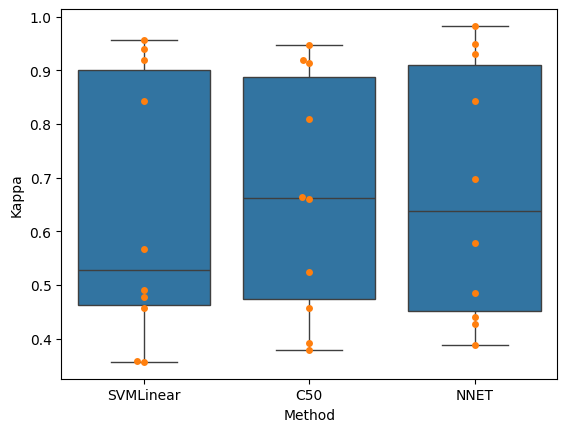

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.boxplot(x='Method', y='Kappa', data=data)
ax = sns.swarmplot(x='Method', y='Kappa', data=data)
plt.show()

<div class="alert alert-info">

**Ejercicio:**

Carga el dataset de IRIS de `scikit-learn.datasets` y entrena un `RandomForest` y un `KNN` con todos los parámetros por defecto. Emplea una validación cruzada de 20 pliegues. Son las diferencias entre los modelos estadisticamente significativas? 

</div>

In [28]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

iris = load_iris()
X = iris.data
y = iris.target

rf_model = RandomForestClassifier(random_state=42)
knn_model = KNeighborsClassifier()

n_folds = 20
rf_scores = cross_val_score(rf_model, X, y, cv=n_folds, scoring='accuracy')
knn_scores = cross_val_score(knn_model, X, y, cv=n_folds, scoring='accuracy')

Calculamos las diferencias y comprobamos la normalidad de las mismas

In [29]:
# verificar normalidad de las diferencias (para test pareado)
print("\n###Test de normalidad de las diferencias (Shapiro-Wilk)")
norm_test = normality(rf_scores - knn_scores)
print(norm_test)

es_normal = norm_test['normal'].values[0]
print(f"Las diferencias {'SÍ' if es_normal else 'NO'} siguen una distribución normal")


###Test de normalidad de las diferencias (Shapiro-Wilk)
         W          pval  normal
0  0.44816  1.116343e-07   False
Las diferencias NO siguen una distribución normal


Hacemos un test estadístico adecuado según si las diferencias son o no normales

In [30]:
if es_normal:
    # si es normal, usamos t-test pareado
    print("Usando t-test pareado (datos normales):")
    resultados_test = ttest(rf_scores, knn_scores, paired=True)
    
else:
    # si no es normal, usamos test de Wilcoxon
    print("Usando test de Wilcoxon (datos no normales):")
    resultados_test = wilcoxon(rf_scores, knn_scores)

print(resultados_test)
p_value = resultados_test['p-val'].values[0]


if p_value < 0.05:
    print(f"\nHay una diferencia estadísticamente significativa entre RandomForest y KNN (p={p_value:.4f} < 0.05)")
else:
    print(f"\nNo podemos decir que exista una diferencia estadísticamente significativa entre RandomForest y KNN (p={p_value:.4f} ≥ 0.05)")

Usando test de Wilcoxon (datos no normales):
          W-val alternative  p-val       RBC    CLES
Wilcoxon    1.0   two-sided    1.0 -0.333333  0.4775

No podemos decir que exista una diferencia estadísticamente significativa entre RandomForest y KNN (p=1.0000 ≥ 0.05)


<div class="alert alert-info">

**Ejercicio:**

Carga los datasets IRIS, Digits, Wine y BreastCancer de `scikit-learn.datasets` y entrena un `RandomForest`, un `KNN` y un `SVM linear` con todos los parámetros por defecto. Son las diferencias entre los modelos estadisticamente significativas? 

</div>

Primero, cargamos los datasets y entrenamos los modelos

In [31]:
from sklearn.datasets import load_iris, load_digits, load_wine, load_breast_cancer
from sklearn.svm import SVC


def load_dataset(name):
    if name == 'iris':
        return load_iris()
    elif name == 'digits':
        return load_digits()
    elif name == 'wine':
        return load_wine()
    elif name == 'breast_cancer':
        return load_breast_cancer()

datasets = ['iris', 'digits', 'wine', 'breast_cancer']
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(kernel='linear', random_state=42)
}

results = pd.DataFrame()

# entrenamos todos los modelos para cada dataset
for dataset_name in datasets:
    dataset = load_dataset(dataset_name)
    X, y = dataset.data, dataset.target
    
    for model_name, model in models.items():
        scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')

        results = pd.concat([results, pd.DataFrame({'dataset': dataset_name, 'model': model_name, 
                                                    'accuracy': np.mean(scores)}, index=[0])], ignore_index=True)

Hacemos un test de normalidad y  de esfericidad

In [32]:
shapiro_a = normality(results.loc[results["model"] == "RandomForest"]['accuracy'], method='shapiro')
shapiro_b = normality(results.loc[results["model"] == "KNN"]['accuracy'], method='shapiro')
shapiro_c = normality(results.loc[results["model"] == "SVM"]['accuracy'], method='shapiro')

print('### Test de normalidad Shapiro-Wilk para el RandomForest')
print(f'### estadístico = {shapiro_a.W.values[0]:.4f}, p-value = {shapiro_a.pval.values[0]:.4f}')

print('### Test de normalidad Shapiro-Wilk para el KNN')
print(f'### estadístico = {shapiro_b.W.values[0]:.4f}, p-value = {shapiro_b.pval.values[0]:.4f}')

print('### Test de normalidad Shapiro-Wilk para el SVM')
print(f'### estadístico = {shapiro_c.W.values[0]:.4f}, p-value = {shapiro_c.pval.values[0]:.4f}')

### Test de normalidad Shapiro-Wilk para el RandomForest
### estadístico = 0.9425, p-value = 0.6694
### Test de normalidad Shapiro-Wilk para el KNN
### estadístico = 0.7318, p-value = 0.0257
### Test de normalidad Shapiro-Wilk para el SVM
### estadístico = 0.8509, p-value = 0.2292


Hacemos un test no paramétrico para medidas repetidas (Friedman). El subject deberá identificar lo que tiene mediciones repetidas; en validación cruzada, generalmente es el fold.

In [33]:
from pingouin import friedman

friedman_result = friedman(data=results, dv='accuracy', within='model', subject='dataset')

print('### Test de Friedman')
print(f'### estadistico = {friedman_result.W.values[0]:.4f} p-value = {friedman_result["p-unc"].values[0]:.4f}')

hay_diferencias = friedman_result['p-unc'].values[0] < 0.05

if hay_diferencias:
    print("Hay diferencias estadísticamente significativas entre los modelos.\n")
    print(f"{pairwise_tests(data = results, dv = 'accuracy', within = 'model', subject = 'fold', parametric = False, return_desc=True)}\n")

else:
    print("No hay diferencias estadísticamente significativas entre los modelos.\n")

### Test de Friedman
### estadistico = 0.0625 p-value = 0.7788
No hay diferencias estadísticamente significativas entre los modelos.



No podemos rechazar la hipótesis nula de que las medianas de los aciertos obtenidos por cada modelo son iguales.

La homocedasticidad es un concepto más general sobre igualdad de varianzas, mientras que la esfericidad es un requisito específico para ANOVA de medidas repetidas relacionado con la varianza de las diferencias entre pares de mediciones.